# Project 1: A RandomForest Approach To Diabetes

## Business Understanding

**Objective:**
* Build a machine learning model to classify diabetes presence (1) or absence (0) based on available health-related features.
* Provide insights into key risk factors and predictive performance of different models.

**Key Questions to Answer:**
* How well can our model predict diabetes based on available variables
* Which variable contributes most to diabetes prediction?
* What is the trade off between precision and recall in our model and what does this mean in healthcare?

## Preparing the Environment

Importing the required libraries to read in the diabetes dataset

* Pandas - For Data Manipulation
* Numpy - For Data Arrays



In [4]:
#libraries needed for Exploratory Data Analysis
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc
)


In [5]:
# Reading in the Dataset in CSV format
dia = pd.read_csv('/Users/Sebbr/Documents/Udacity 1/diabetes.csv')

# Exploratory Data Analysis
In this Section We:
* Explore Data Overview
* Perform Data Quality Checks
  

#### Explore Data Overview

In [8]:
# Exploring the data overview with df.info, df.head and df.describe
dia.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
dia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
dia.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**From this Initial EDA we understand that our dataset has:**
* Loaded in correctly
* 768 entries
* 8 Independant Variables
* 1 Dependant Variables (Outcome)
* Has expected data distribution within each feature

#### Perform Data Quality Checks

**In this section we examine our data for:**
* Completeness (missing data)
* Duplication
* Anomalous Results


In [13]:
# Examining for missing values (Note: 0 NA values found)
dia.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [14]:
# Examining for Duplicated Results
dia.duplicated().sum()

0

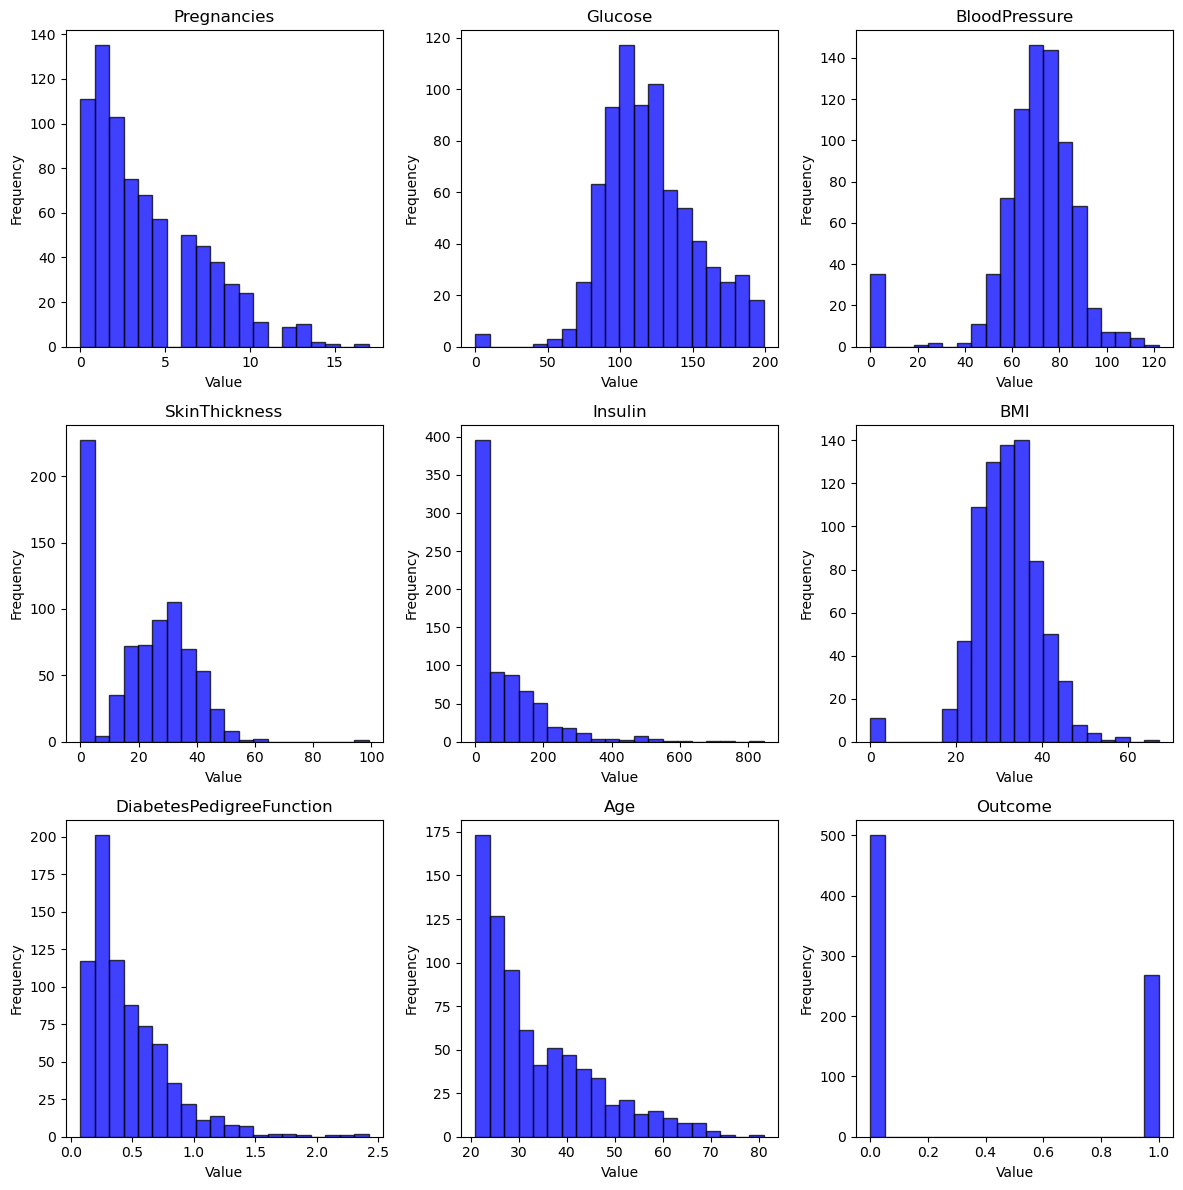

In [86]:
# Visualising Each Varible to understand Data Distribution for outliers in data points

def plot_histograms(data):
    """
    Returns plots of histograms for selected features of a given dataset.
    
    input: The Dataset for historgrams to be made of

    output:
    Each histogram displays the distribution of values within the dataset.
    """
    features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
    
    plt.figure(figsize=(12, 12))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        plt.hist(data[feature], bins=20, edgecolor='black', alpha=0.75, color='blue')
        plt.title(feature, fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_histograms(dia)


# A Machine Random Forest Learning Method
**A RandomForest Approach is best suited here for a variety of reasons including:**
* A Reduction in Over-fitting
* The Understanding of interacitons among features
* It is good a dealing with an imbalance in data (K-fold Cross-Validation)

## Splitting the Data
* Dataset for Independant (X)
* Dataset just of Dependant (Y)
* Training Data (80%)
* Test Data (20%)

In [18]:
# Splitting the data into independance (X) and Dependant (Y) using .drop()
X = dia.drop('Outcome', axis = 1)
Y = dia['Outcome']

#Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

## Our Random Forest Model
* Fitting the RF Model
* Assessing the Accuracy of our Model
* Tuning our Model
* Re-Assessing Accuracy

In [20]:
# Fitting the RF Model
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [21]:
# Assessing the accuracy of the model on the 20% unseen data
Y_pred = rf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.7597402597402597


Our First Model Shows Accuracy of 0.77 **_without hyperparameter tuning_**. This means that the model is correctly predicting both the positive and negative cases at a 77% accuracy

## Tuning Our RF Model
**Here we aim to tune:**
* Number of Trees (n_estimators)
* Depth of each tree (max_depth)
* Minimum Sample Split (min_samples_split)
* Minimum Samples per leaf (min_samples_leaf)
* Implement K-Fold Cross Validation

In [24]:
# Re-Initialise Our 75% Accurate Random Forest Classifier
rf2 = RandomForestClassifier()
rf2.fit(X_train, Y_train)

RandomForestClassifier()

In [25]:
# The Tuning Parameters we are interested in:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}
# Using Stratified K-folds for equal class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Systematically testing combinations of hyperparameters with grid_search
grid_search = GridSearchCV(rf2, param_grid, cv = skf, scoring = 'f1')
grid_search.fit(X, Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [26]:
#Looking at the most optimal hyper-paramter tuning
best_rf_para = grid_search.best_estimator_
# Identifying what those hyperparameters are
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [27]:
# Training the most optimised classification model for final evaluation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)
best_rf_para.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, n_estimators=300)

## Evaluating our Tuned Hyper-parameter model

In [29]:
# Assessing the accuracy of the model on the 20% unseen data on our tuned RF model
Y_pred = best_rf_para.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.7532467532467533


**Through our hyper-parameter tuning we have increased the accuracy of our model to 86%**

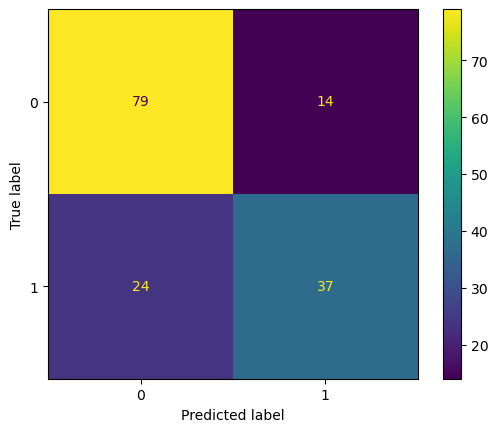

In [31]:
# Evaluating the Confusion Matrix of Our Model
cm = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

**The Confusion Matrx shows:**
* 31 True Postives and 101 True Negatives for people with and without diabetes respectivally
* Our model has high false negatives (13) indicating potential issues in recall for the diabetic class

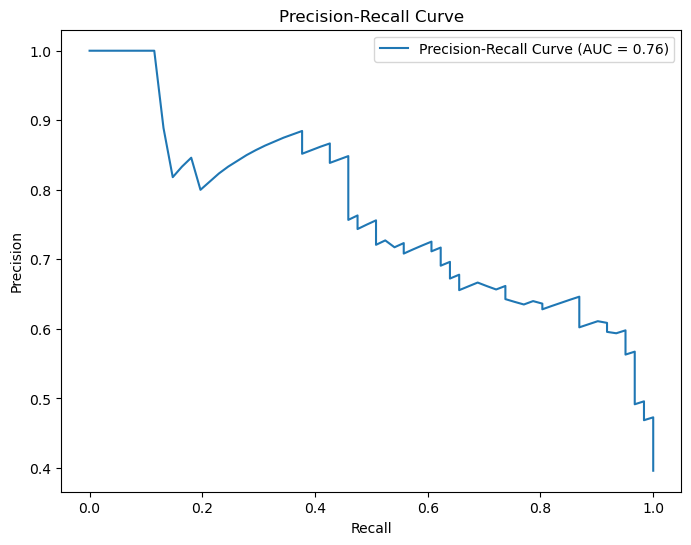

In [33]:
# Evaluating our AUC/ROC curve
# Predict probabilities for positive class
Y_scores = best_rf_para.predict_proba(X_test)[:, 1]
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
# Calculate Area Under the Curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Understanding Our Precision - Recall Curve:**

Precision-Recall Curve helps evaluate the RF classification performance. This graph demonstrates an AUC of 0.66 (moderate performance) meaning our model is distinguishing between diabetic and non-diabetic cases but there is room for improvement. Since early detection is crucial in healthcare, we might want to increase recall even if it slightly lowers precision. 

## Imagining A New Scenario for the RF Model
**In this New Scenario:** 
* A healthcare professional has a new patient and wants to know the likelyhood that they have diabetes or not. 
* They also want to advice the patient where to focus there effort to reduce the risk of developing diabetes in the future


In [36]:
variable_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                 "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

# Create a DataFrame for the new patient
new_patient = pd.DataFrame([[2, 150, 80, 20, 85, 30.0, 0.6, 45]], columns=variable_names)

In [37]:
#Predicting the likelyhood of diabetes
prediction = best_rf_para.predict(new_patient)
print(prediction)

[1]


**The model predicts the patient is likely to have diabetes. A doctor might use this result as a signal to conduct further medical tests.**

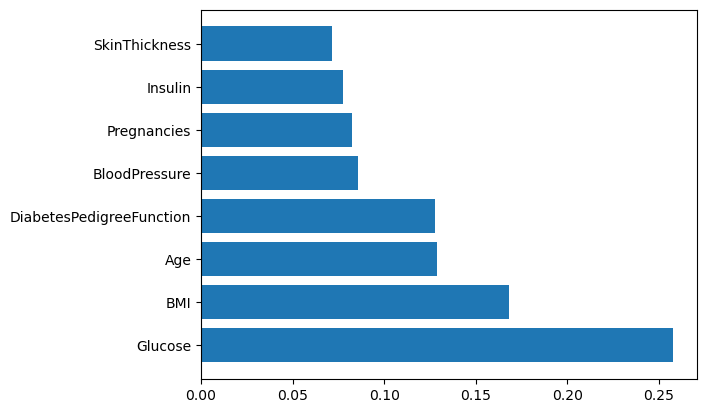

In [39]:
#Assessing the variable importance of our variables in predicting the pressence of diabetes
variable_importance = best_rf_para.feature_importances_
#Creating dataframe for visualisation
variable_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                 "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
importance_df = pd.DataFrame({"Variable": variable_names, "Importance": variable_importance})
# Sort features by importance (descending)
importance_df = importance_df.sort_values(by="Importance", ascending=False)
#Plotting the 
plt.barh(importance_df["Variable"], importance_df["Importance"])
plt.show()

Through understanding the most helpful indicators of diabetes a doctor can advise more effective change to a patient to create more meaningful outcomes. In this scenario our model predicts **glucose** as the variable with the most importance in tackling/predicting diabetes. As such doctors can prescribe/advice based on this factor intially in helping the patient prevent diabetes in the future.